In [1]:
using JLD
using PyPlot
using Statistics, StatsBase
using Clustering
using Distances  # Este es necesario para hacer la matriz de distancia, es complemento a Clustering.

In [2]:
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools # pa aprovechar las cosas que ya tenemos.

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/ArraySetTools.ji for ArraySetTools [top-level]
└ @ Base loading.jl:1190


In [3]:
function normalizar1(xx::Array)
    norma=maximum(abs.(xx))
    result=xx./norma
    return result
end

normalizar1 (generic function with 1 method)

In [4]:
function filtraclusterchicos(puntos::Array, clustree, umbral)
    tabla=hcat(puntos,clustree)
    valores=unique(clustree)
    dd=Dict([(i,count(x->x==i,clustree)) for i in valores])
    predicado(j)=dd[j]>umbral
    result=tabla[map(x->predicado(x), clustree),:]
    (clusterfuck, cual)=findmax(dd)
    println("el cluster mayor tiene ",clusterfuck, " elementos, es el ", cual)
    return result
end

function filtraclusterchicos(puntos::Dict, umbral)
    # no solo aqui ya estan separados por dicctionario, sino tambien
    # en "electrodos", es decir numeros enteros
   result=Dict{Int, Set}()
    for k in keys(puntos)
        if length(puntos[k])>umbral
            result[k]=puntos[k]
        end
    end
    return result
end

filtraclusterchicos (generic function with 2 methods)

In [5]:
function declustaset(puntosyclust::Array; enteros=true)
    #= la funcion convierte el cluster en una tabla
    a un conjunto de enteros, sobre una malla 
    =#
    result=Dict{Int,Set}()
    clustnames=unique(puntosyclust[:,5])
    for q in clustnames
        subt=puntosyclust[puntosyclust[:,5].==q,:]
        if enteros
            punt=rowstoset(round.(Int64,subt[:,1:2]))
        else
            punt=rowstoset(subt[:,1:2], enteros=enteros)
        end    
        qindez=round(Int64,q)
        result[qindez]=punt
    end
    return result
end



declustaset (generic function with 1 method)

In [59]:
#funcion solo para plotear, no se si luego la vas a usar.
function dictatabla(dict::Dict; una=true)
    # si una, entonces todo va en una tabla, si no, va en tablitas separadas
    if una 
        aux=[0 0 0]
    else
        aux=Dict{Any, Any}()
    end
    
    for q in keys(dict)
        
        aux2=[0 0]
        
        for renglon in dict[q]
            aux2=vcat(aux2, renglon)
        end
        
        aux2=aux2[2:end,:]
        (l,k)=size(aux2)
        columnaextra=ones(Int64, l).*q
        aux3=hcat(aux2, columnaextra)
        
        if una
            aux=vcat(aux, aux3)
        else
            aux[q]=aux2
        end
    end
    
    if una
        return aux[2:end,:]
    else
        return aux
    end
end


dictatabla (generic function with 1 method)

In [7]:
nombrecm="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_prepro-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP)

2000

In [8]:
# Datos ordenados 4dimensionalmente.
# vamos a usar masa maxima y tiempo maximo normalizados a 64 (dist max.)
# para hacer un hipercubo platonico y hacer el apiñonamiento jerárquico ahi.

fruncio=Array{Float64}(undef, 0,4)

for k in keys(DatosCMP)
    dat=DatosCMP[k]
    (alto, ancho)=size(dat)
    auxt=ones(alto).*k
    afafa=hcat(dat, auxt)
    fruncio=vcat(fruncio,afafa)
end

In [9]:
masamax=maximum(fruncio[:,3])

12329.550282478333

In [10]:
nmax=maximum(fruncio[:,4])

2000.0

In [11]:
function plot4Ddiscs(datos::Array)
    figure(figsize=(8,6.5))
    
    xx=datos[:,1]
    yy=datos[:,2]
    gordis=datos[:,3]
    nn=datos[:,4]
    
    xlim(0.0,65.0)
    ylim(0.0,65.0)
    
    
    scatter(xx,yy, s=0.05*gordis, edgecolors="darkmagenta", c=nn, cmap="plasma")
    colorbar()
    show()
end


plot4Ddiscs (generic function with 1 method)

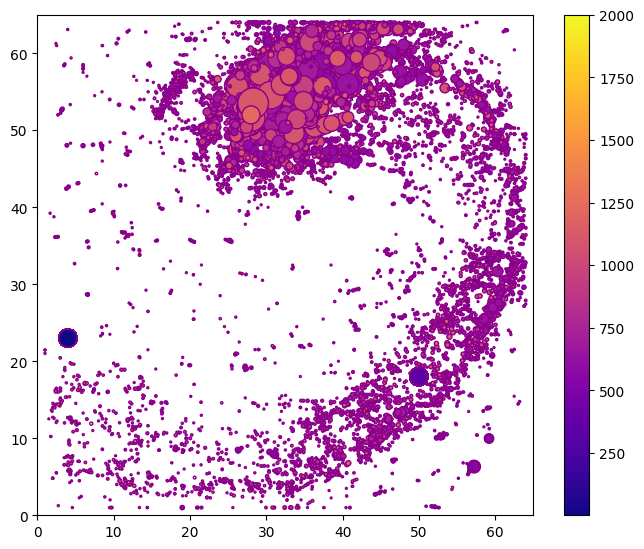

In [12]:
fig=plot4Ddiscs(fruncio)


In [13]:
histogordis=fit(Histogram, fruncio[:,3], 1:20:5001)

Histogram{Int64,1,Tuple{StepRange{Int64,Int64}}}
edges:
  1:20:5001
weights: [0, 386, 2840, 1481, 885, 491, 324, 242, 178, 162  …  1, 3, 3, 1, 3, 3, 1, 1, 3, 0]
closed: left
isdensity: false

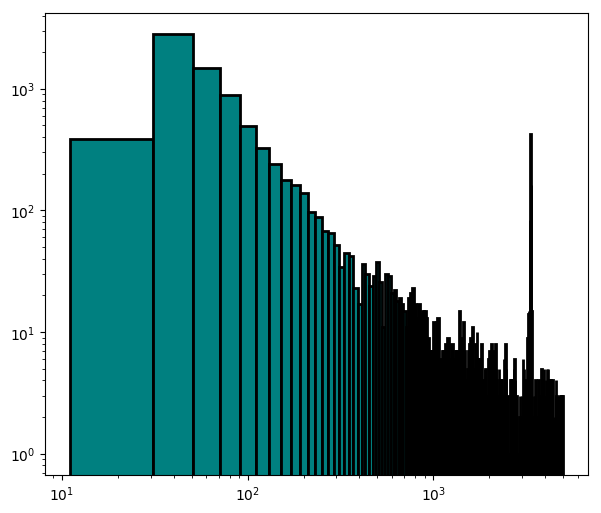

In [14]:
#histogordis.weights
figure(figsize=(7,6))
bar(histogordis.edges[1][1:end-1], histogordis.weights, width=20, 
    color="teal", edgecolor="k", linewidth=2)
yscale("log")
xscale("log")
show()

In [17]:
gmin=nquantile(fruncio[:,3], 10)[2]

44.147528648376465

In [18]:
frunciofiltrado=fruncio[fruncio[:,3].>gmin,:]
size(frunciofiltrado)

(8856, 4)

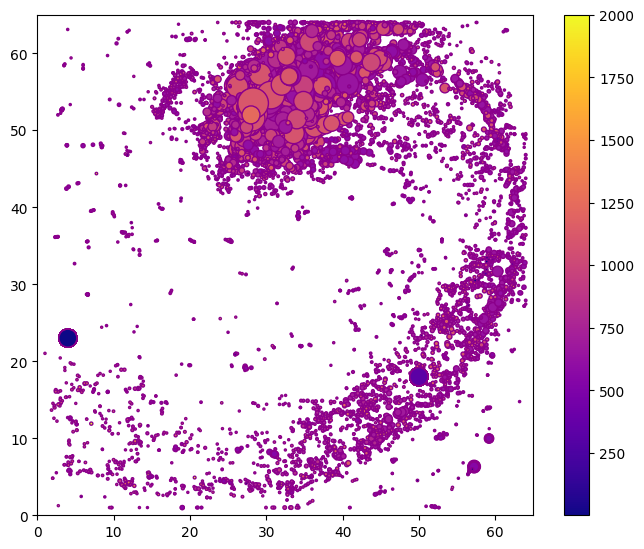

In [19]:
plot4Ddiscs(frunciofiltrado)


In [20]:
# clust1=fruncio[:,1:2];
clust1=permutedims(frunciofiltrado)

4×8856 Array{Float64,2}:
   49.9978    31.7893    10.2865   …    28.0012    44.7566    49.9984
   18.0004    60.9192     7.00301       51.9968    54.6292    17.9983
 3355.89      82.6364    81.8873      3339.65      85.3075  3345.59  
  306.0     1316.0     1316.0         1241.0     1241.0      322.0   

In [21]:
clust1[3,:]=normalizar1(clust1[3,:]).*64
clust1[4,:]=normalizar1(clust1[4,:]).*64;

In [22]:
clustspaciotiempo=vcat(clust1[1:2,:], transpose(clust1[4,:]))

3×8856 Array{Float64,2}:
 49.9978  31.7893  10.2865   38.625   …   8.03761  28.0012  44.7566  49.9984
 18.0004  60.9192   7.00301  63.6998     15.7911   51.9968  54.6292  17.9983
  9.792   42.112   42.112    42.656      39.712    39.712   39.712   10.304 

In [23]:
# decisiones, decisiones
dd4d=pairwise(Euclidean(), clust1, dims=2);
dd3d=pairwise(Euclidean(), clustspaciotiempo, dims=2);
dd2d=pairwise(Euclidean(), clust1[1:2,:], dims=2);

In [24]:
h4d=hclust(dd4d)
h3d=hclust(dd3d)
h2d=hclust(dd2d)

Hclust{Float64}([-1808 -3212; -3112 -6440; … ; 5286 8853; 4636 8854], [9.36836e-6, 1.08421e-5, 2.18722e-5, 2.27687e-5, 2.388e-5, 2.38943e-5, 2.3937e-5, 2.90832e-5, 3.26346e-5, 3.26485e-5  …  3.89438, 3.93271, 4.08506, 4.10886, 4.23181, 4.28125, 4.37309, 4.37604, 4.53162, 4.92297], [6809, 5035, 1456, 2089, 5570, 942, 4236, 2120, 5069, 797  …  5016, 756, 3579, 3602, 1470, 2688, 1912, 383, 2128, 6844], :single)

In [25]:
hcorta=0.95 #estrictamente menos que un electrodo.
clust4d=cutree(h4d,h=hcorta)
clust3d=cutree(h3d,h=hcorta)
clust2d=cutree(h2d,h=hcorta);

In [26]:
size(unique(clust4d))

(2703,)

In [27]:
function scatterclust(puntos, clustn)

fafa=figure(figsize=(4,4))
#axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(puntos[:,1],puntos[:,2], s=0.5, c=clustn, cmap="inferno")
colorbar(fraction=0.045)
end

scatterclust (generic function with 1 method)

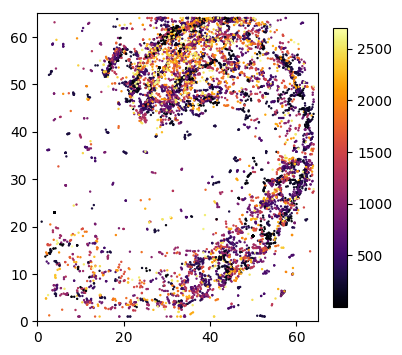

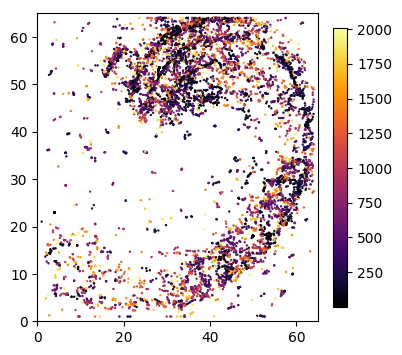

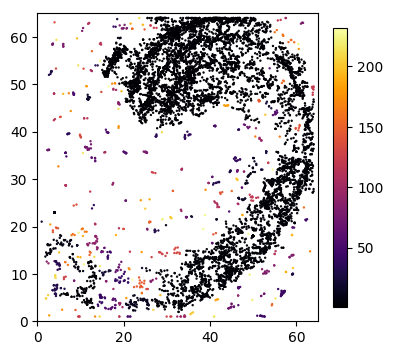

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9299188da0>

In [28]:
scatterclust(frunciofiltrado, clust4d)
scatterclust(frunciofiltrado, clust3d)
scatterclust(frunciofiltrado,clust2d)

In [75]:
temp=hcat(frunciofiltrado, clust4d)
dict4d=declustaset(temp, enteros=true)
blabla=filtraclusterchicos(dict4d, 5);

In [76]:
blatabla=dictatabla(blabla);

buf=dictatabla(blabla, una=false)

Dict{Any,Any} with 50 entries:
  148  => [23 50; 23 52; … ; 24 51; 23 49]
  985  => [20 57; 19 58; … ; 18 57; 18 56]
  2    => [33 62; 30 61; … ; 31 62; 33 61]
  1040 => [29 45; 32 44; … ; 31 44; 30 44]
  158  => [58 49; 57 48; … ; 56 48; 56 46]
  160  => [58 30; 61 30; … ; 60 28; 60 29]
  144  => [44 14; 41 13; … ; 43 15; 43 14]
  1024 => [31 46; 32 46; … ; 30 46; 31 47]
  106  => [52 27; 52 29; … ; 53 30; 52 28]
  18   => [29 60; 29 58; … ; 28 57; 30 58]
  388  => [39 13; 38 12; … ; 38 11; 40 14]
  121  => [60 56; 59 54; … ; 58 53; 58 54]
  84   => [54 18; 55 19; … ; 53 19; 54 19]
  958  => [58 33; 58 32; … ; 56 32; 57 32]
  168  => [56 56; 57 54; … ; 58 53; 58 54]
  662  => [62 39; 63 37; … ; 62 38; 61 37]
  105  => [24 49; 23 50; … ; 23 49; 22 48]
  373  => [38 10; 38 9; … ; 39 10; 39 7]
  455  => [46 55; 47 54; … ; 47 53; 46 54]
  605  => [17 55; 19 57; … ; 18 56; 18 54]
  128  => [63 41; 63 42; … ; 64 44; 63 43]
  481  => [26 45; 24 45; … ; 26 46; 25 46]
  379  => [39 60; 41 59; 

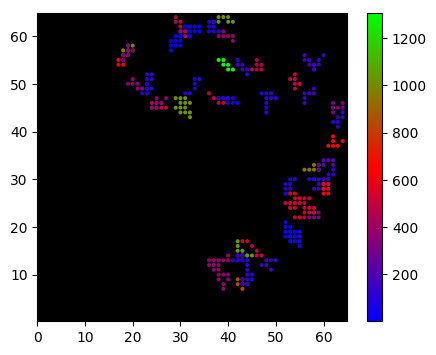

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9216320d30>

In [77]:
fafa=figure(figsize=(5,4))

ax=gca()
ax.set_facecolor("k")
axis("equal")

xlim(0.0,65.0)
ylim(0.0,65.0)
scatter(blatabla[:,1], blatabla[:,2], c=blatabla[:,3], s=3.5, cmap="brg")
colorbar()

In [50]:
using QHull

┌ Info: Precompiling QHull [a8468747-bd6f-53ef-9e5c-744dbc5c59e7]
└ @ Base loading.jl:1192


In [78]:
convexas=Dict{Any, Any}()
for k in keys(buf)
    puf =buf[k]
    print(k, " ")
    ch = chull(puf)
    convexas[k]=ch
end

148 985 2 1040 158 160 144 1024 106 18 388 121 84 958 168 662 105 373 455 605 128 481 379 157 231 467 363 325 500 1025 1045 167 100 504 343 845 122 62 321 1305 129 562 123 116 28 514 502 653 369 97 

In [106]:
poly=PyPlot.matplotlib.patches.Polygon
appnplot=PyPlot.matplotlib.patches
colect=matplotlib.collections.PatchCollection

PyObject <class 'matplotlib.collections.PatchCollection'>

In [104]:
keys(colect)

40-element Array{Symbol,1}:
 :AsteriskPolygonCollection
 :BrokenBarHCollection     
 :CIRCLE_AREA_FACTOR       
 :CircleCollection         
 :Collection               
 :EllipseCollection        
 :EventCollection          
 :LineCollection           
 :Number                   
 :PatchCollection          
 :PathCollection           
 :PolyCollection           
 :QuadMesh                 
 ⋮                         
 :cm                       
 :docstring                
 :k                        
 :math                     
 :mcolors                  
 :mlines                   
 :mpath                    
 :mpl                      
 :np                       
 :patchstr                 
 :transforms               
 :warnings                 

In [93]:
orderhull=Dict{Any, Any}()
for k in keys(convexas)
    plaf=[0 0]
    for j in convexas[k].vertices
        aux=transpose(convexas[k].points[j,:])
        plaf=vcat(plaf, aux)
    end
    orderhull[k]=plaf[2:end,:]
end

In [125]:
#f=figure(figsize=(6,6))
fig, ax = plt.subplots()
popo=[]
for k in values(orderhull)
    punch=poly(k, true)
    push!(popo, punch)
end
cucu=colect(popo, alpha=0.5)
cucu.set_array(1:50)
ax.add_collection(cucu)
fig.colorbar(cucu, ax=ax)

Figure(PyObject <Figure size 640x480 with 2 Axes>)

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9202b8c7b8>

In [127]:
popo

50-element Array{Any,1}:
 PyObject <matplotlib.patches.Polygon object at 0x7f9298d9eac8>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298d9ebe0>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298d9ecf8>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298d9ee10>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298d9ef28>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298dca080>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298dca198>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298dca2b0>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298dca3c8>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298dca4e0>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298dca5f8>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298dca710>
 PyObject <matplotlib.patches.Polygon object at 0x7f9298dca828>
 ⋮                                                             
 PyObject <matplotlib.patches.Polygon object at 0x7f9298d90518>
 PyObject <matp